# Background images generation

Apply OTSU filter on boxes detected to extract white blood cell mask. Remove the cell and fill in the gap with background color.

In [1]:
import sys, os, glob
sys.path.append("../code/src")
from cdc.utils.background import *
import pandas as pd
from PIL import Image
from tqdm import tqdm

In [2]:
DATA_HOME = "../data"
IMAGES_HOME = os.path.join(DATA_HOME, "images_cytologia")
BACKGROUND_HOME = os.path.join(DATA_HOME, "background")
BACKGROUND_IMAGES = os.path.join(DATA_HOME, "background_images.csv")
os.makedirs(BACKGROUND_HOME, exist_ok=True)

In [3]:
# Load OOF from YOLOX object detector
oof_pd = pd.read_parquet(os.path.join(DATA_HOME, "cv4_seed42_multilabel_oof_yolox_s_512_v3.1.parquet"))
# Filter on single WBC detected with high confidence (around 3.5k images selected)
df = oof_pd[(oof_pd["oof_bbs"] == 1) & (oof_pd["NAME"].isin(pd.read_csv(BACKGROUND_IMAGES)["filename"].unique()))].sort_values(["bb_score_avg"], ascending=[False]).reset_index(drop=True)
print(df.shape)
df.head()

(3469, 49)


,NAME,img_width,img_height,fold_s42,oof_bbx,bb_score_avg,oof_roi_width_max,oof_roi_height_max,oof_bbs,filename,...,LM,LZMG,SS,multilabel,surface_bin,bb_avg_surface_ratio_bin,mean_bin,std_bin,trustii_ids,trustii_bbs
0,3db4e459-e.jpg,360,360,1.0,"[[107.0, 257.0, 96.0, 265.0, 0.0, 19.560185185...",0.981462,150.0,169.0,1,images_cytologia/3db4e459-e.jpg,...,0.0,0.0,0.0,8,0.0,1.0,3.0,3.0,[12805],NaN
1,21b46c32-6.jpg,360,360,1.0,"[[111.0, 251.0, 111.0, 253.0, 0.0, 15.33950617...",0.980975,140.0,142.0,1,images_cytologia/21b46c32-6.jpg,...,0.0,0.0,0.0,8,0.0,0.0,3.0,3.0,[7026],NaN
2,6f6d48c4-1.jpg,360,366,3.0,"[[119.0, 244.0, 121.0, 249.0, 0.0, 12.14329083...",0.980966,125.0,128.0,1,images_cytologia/6f6d48c4-1.jpg,...,0.0,0.0,0.0,0,0.0,0.0,3.0,2.0,[23022],NaN
3,4b99f9b3-b.jpg,368,369,3.0,"[[116.0, 254.0, 116.0, 255.0, 0.0, 14.12601626...",0.980966,138.0,139.0,1,images_cytologia/4b99f9b3-b.jpg,...,0.0,0.0,0.0,0,0.0,0.0,3.0,2.0,[15693],NaN
4,51d177dc-b.jpg,360,360,2.0,"[[111.0, 248.0, 113.0, 251.0, 0.0, 14.58796296...",0.980487,137.0,138.0,1,images_cytologia/51d177dc-b.jpg,...,0.0,0.0,0.0,14,0.0,0.0,3.0,2.0,[16921],NaN


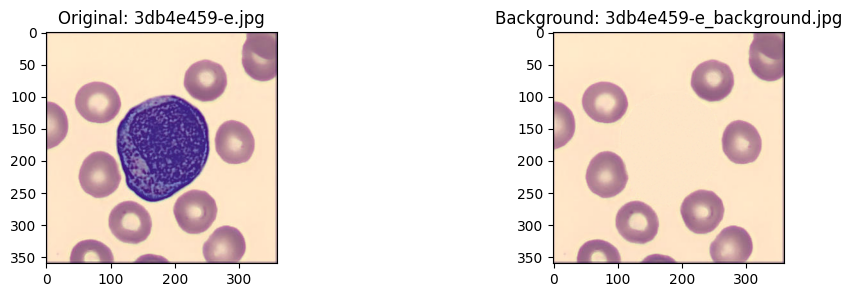

In [4]:
# Dump background images in a folder
for idx, row in df.iterrows():
    name = row["NAME"]
    oof_bbx = row["oof_bbx"]
    img = np.array(Image.open(os.path.join(IMAGES_HOME, name)))

    margin = 16
    for x1, x2, y1, y2, klass, surface, score in oof_bbx:
        x1 = x1 - margin
        y1 = y1 - margin
        x2 = x2 + margin
        y2 = y2 + margin        
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        break
    
    # Run OTSU filter based on boxes
    bg_img = remove_wbc(img, x1, y1, x2, y2,  
                        bg_thr = 150, kernel_size_color = (24, 24), 
                        kernel_size = (8, 8), noise_intensity=8, 
                        noise_fraction=0.10, 
                        verbose=False)
    
    bg_filename = "%s_background.jpg" % name.replace(".jpg", "")
    
    if idx == 0:
        fig, ax = plt.subplots(1, 2, figsize=(12, 3))
        d = ax[0].imshow(img)
        d = ax[0].set_title("Original: %s" % name)
        d = ax[1].imshow(bg_img)
        d = ax[1].set_title("Background: %s"%bg_filename)
        d = plt.show()
    
    Image.fromarray(bg_img).save(os.path.join(BACKGROUND_HOME, bg_filename))